# Aerocraft Log Analytics

1.Combine all flight-launching dataset into one huge dataset(launch.csv). If this part donesn't work, please directly import launch dataset.

In [5]:
import pandas as pd
import os

In [6]:
cwd = os.getcwd()

In [ ]:
#combine all launches dataset to one
##the name of combined dataset for launches      
SaveFile_Name = 'launch.csv'    
# get a list of all file names
file_list = os.listdir()
df = pd.read_csv( file_list[1]) 
df['flight']=file_list[1][7:12]
df.to_csv( cwd + '\\' + SaveFile_Name, encoding="utf_8",index=False)
for i in range(1,len(file_list)-3):
    df = pd.read_csv( file_list[i] )
    df['flight']=file_list[i][7:12]
    df.to_csv(cwd + '\\' + SaveFile_Name,encoding="utf_8",index=False, header=False, mode='a+')

In [8]:
data=pd.read_csv('launch.csv') 

In [9]:
data.shape

(448277, 20)

2. Try to plot all trajactories in 3-D spaces based on the position_ned_m[i] variables in 3 dimensions. Of course it would be better if I can plot an animation.

In [10]:
#get all flight numbers
flight_lst=list(data['flight'].unique())

In [11]:
#name scatter points in batches to plot all trajactories for all flights to avoid manually name the variables
for i in flight_lst:
    locals()['launch_'+str(i)]=data[data['flight']==i]
    exec('num{}=launch_{}.shape[0]'.format(i,i))
    exec('x{}, y{}, z{} =launch_{}["position_ned_m[0]"], launch_{}["position_ned_m[1]"], launch_{}["position_ned_m[2]"]'.format(i,i,i,i,i,i))

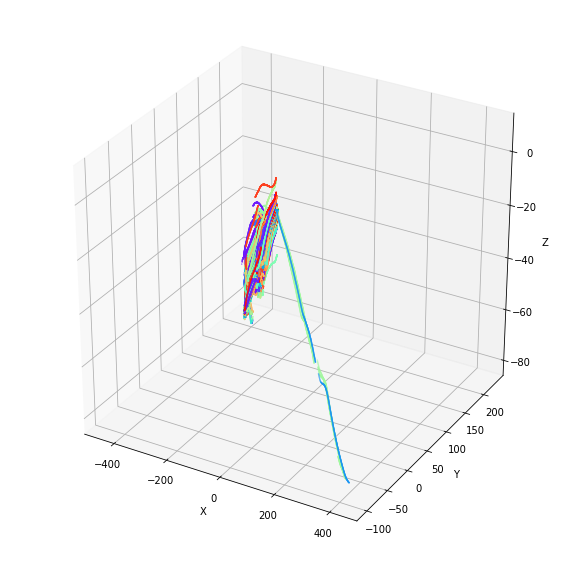

In [12]:
#plot the trajactories for all flights
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
% matplotlib inline 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(flight_lst)))
for i,c in zip(flight_lst,colors):
    exec('ax.scatter(x{}[:num{}], y{}[:num{}], z{}[:num{}], c=c,s=0.2)'.format(i,i,i,i,i,i))
ax.set_zlabel('Z')  
ax.set_ylabel('Y')
ax.set_xlabel('X')
plt.show()

* As for the first question, based on the plot above, we can find there were a few launches that went to the opposite direction(south) within 20 seconds. However, we still need to zoom in to check if there were any other anomalies that happened near the distribution center(x=0,y=,z=0), so I adjusted the scales for three axes.In order to do that, I plotted the distribution of positions in three directions to descide on the scale and to make sure the 3-D plot starting from the launching point. Also, I made all trajactories starting from the left bottom side.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


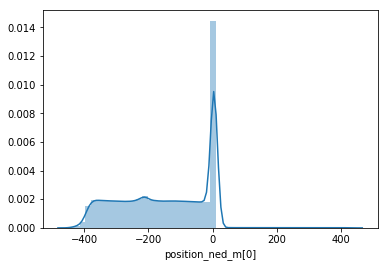

In [13]:
import seaborn as sns
sns.distplot(data['position_ned_m[0]'])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


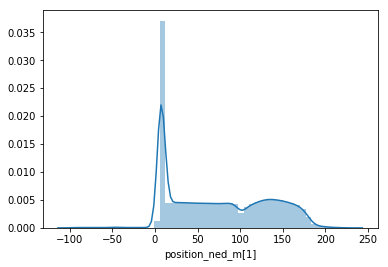

In [14]:
sns.distplot(data['position_ned_m[1]'])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


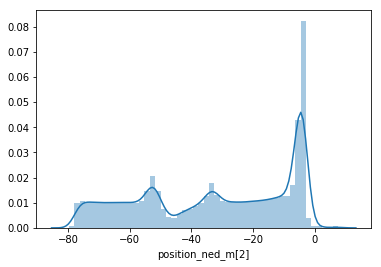

In [15]:
sns.distplot(data['position_ned_m[2]'])

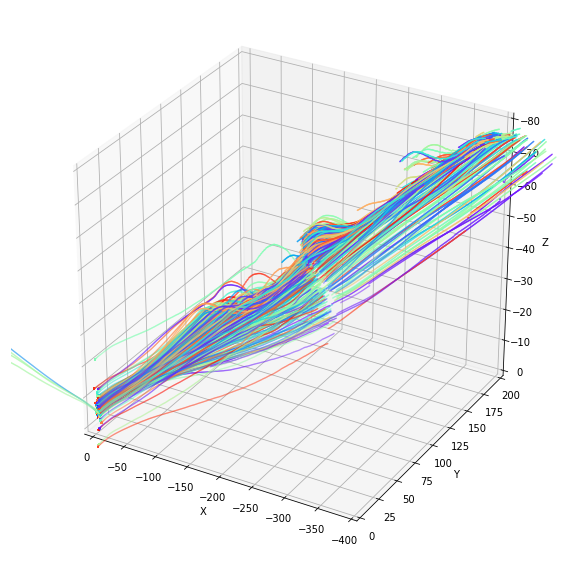

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(flight_lst)))
for i,c in zip(flight_lst,colors):
    exec('ax.scatter(x{}[:num{}], y{}[:num{}], z{}[:num{}], c=c,s=0.2)'.format(i,i,i,i,i,i))
ax.set_zlabel('Z')  
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_xlim([5,-400])
ax.set_ylim([0,200])
ax.set_zlim([0,-80])
plt.show()

* As we can see, all flights started from left bottom side(distribution center) and most rose to right-hand side. Few went to the opposite for some reasons that I don't know.Probably there were some malfunctions ot it also could be doing the right thing and just followed the orders.
  
  Also, there are gaps in the middle of the flights. Given the timestamp intervals are quite constant, I blieve there were speed accelerations at that point. 
  
  The launching points for all these flights were actually different, especially on the z axis(the down direction), so I got the unique values of position_ned_m[2] to see why in the following.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


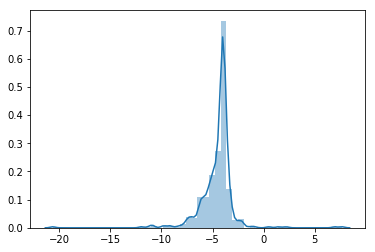

In [17]:
z_dic={}
for i in flight_lst:
    exec('z_dic[{}]=z{}.iloc[0]'.format(i,i))
sns.distplot(list(z_dic.values()))

In [18]:
#Flights that were launched higher than 10 units relative to a fixed reference point
{k: v for k, v in z_dic.items() if v < -10}

{16991: -10.908928,
 17359: -20.62155,
 17459: -10.847755,
 17660: -11.146791,
 17702: -11.959343}

I thought all flights were designed to launch from the same places or even launching points that were close to each other before I dived into the dataset.
Good to know that it's not true.

3.Question 2: Outlier Detection

Steps:clean the dataset, create variables, z-scale to standardize, PCA, z-scale again.
Then, compute two scores to evaluate how deviated the records were from the general trend:

* Baesd on the youtube vedioes of zip launching, I assume the trajactories of different launches should be similar at the beginning of the launches. The delivery of orders from different destinations is conducted by the subsequent automatic navigation.

The first score:a heuristic model that measures the euclidean distance of a point from the
origin. The thought process is that the bulk of the properties will
lie within a certain radius from the origin, whereas the outliers would be relatively far away.
Score 1 is therefore the absolute distance from the origin and is equal to the square root of the
summation of the squared absolute value of the eight Z-scores.
$$S1_i=\sqrt{\sum_{k}|z_{k,i}|^2}$$  i:different flights; 
k:the variables we selected after PCA.

The autoencoder score:I built an one-layer autoencoder model to get the reproduced z-values.The score is the square root of the sum of the differences in the squares of the
reproduced and the original z-values. On an intuitive scale, it measures the euclidean distance
between the original point and the reproduced point in the n-dimensional surface. If the points
are reproduced well, then this distance should be close to 0. If they aren’t, then the distance will
be large.Here, the accuracy of the autoencoder is not important, so I just chose one hidden layer.  $$S2_i=\sqrt{(\sum_{k}|z_{k,ri}-z_{k,i}|^2)}$$ zk,ri:the reproduced data   
zk,r:the original data

After obtaining Score 1 and Score 2 for all the fields, they are separately ordered by the
magnitude of the two scores and are assigned a rank determining their position in the two
ordered ranges. In this way Score 1 and Score 2 are no longer numerical values from different
distributions, but they have now been converted to ranking numbers based on the magnitudes of
Score 1 and 2.
The final score is calculated as the average of the two ranks for a particular field.

Test if there are any missing values, which turns out to be none. Good to go to the next step.If I have more time, I will make a data quality report containing the distributions of all variables to help the further analysis.

In [19]:
data.isnull().sum()

seconds_since_launch          0
position_ned_m[0]             0
position_ned_m[1]             0
position_ned_m[2]             0
velocity_ned_mps[0]           0
velocity_ned_mps[1]           0
velocity_ned_mps[2]           0
accel_body_mps2[0]            0
accel_body_mps2[1]            0
accel_body_mps2[2]            0
orientation_rad[0]            0
orientation_rad[1]            0
orientation_rad[2]            0
angular_rate_body_radps[0]    0
angular_rate_body_radps[1]    0
angular_rate_body_radps[2]    0
position_sigma_ned_m[0]       0
position_sigma_ned_m[1]       0
position_sigma_ned_m[2]       0
flight                        0
dtype: int64

3.1Create variables

Eventually I want to get one dataset whose rows are different flights and columns are the variables I built.Since we have 447 flights, we can't have # of variables more than 447, otherwise we will get infinite solutions. Although we will also use PCA to reduce the dimensionality, I think it's still better for us to have less variables from the beginning.

I want to combine the timestamps with the given 20 variables except the timestamp to generate new variables, so as to measure the flight performances during different periods.However, both the timestamp granualities and intial time for all flights are different, so I decide to lower the accuracy of time, generalize the performance within that time by calculating the mean.Baesd on the knowledge I have about physics now, I think mean can somehow be used to generalize them.I also tried other metrics, but none made sense. For all, I chose 1s as the new time granuality.Therefore # of variables that we have is #of seconds* # of variables$21*18=378$ variables before PCA.

I don't have much background about aerospace，but if I have more resources, I think it would be better if I could ask experts about this variable creation to avoid information missing. Probably taking the time interval like 0.1s can help us target when launches had problems more accurately. Of course, it will come with more variables, which could take more computing power.

In [20]:
#approximate the timestamp to 1 decimal
data['newtime']=round(data['seconds_since_launch'],0)

In [21]:
newdata=data.groupby(['flight','newtime']).agg({'position_ned_m[0]':'mean','position_ned_m[1]':'mean','position_ned_m[2]':'mean',\
                                               'velocity_ned_mps[0]':'mean','velocity_ned_mps[1]':'mean','velocity_ned_mps[2]':'mean',\
                                               'accel_body_mps2[0]':'mean','accel_body_mps2[1]':'mean','accel_body_mps2[2]':'mean',\
                                               'orientation_rad[0]':'mean','orientation_rad[1]':'mean','orientation_rad[2]':'mean',\
                                               'angular_rate_body_radps[0]':'mean','angular_rate_body_radps[1]':'mean','angular_rate_body_radps[2]':'mean',\
                                               'position_sigma_ned_m[0]':'mean','position_sigma_ned_m[1]':'mean','position_sigma_ned_m[2]':'mean'})

In [22]:
newdata=newdata.reset_index()
newdata[['newtime']] = newdata[['newtime']].astype(str)

In [23]:
#variable reference dictionary for the timestamp, which explains the number behind slash
dict={}
for i,j in zip(newdata['newtime'].unique(),range(1,202)):
    dict[i]=j

In [24]:
dict

{'-5.0': 1,
 '-4.0': 2,
 '-3.0': 3,
 '-2.0': 4,
 '-1.0': 5,
 '-0.0': 6,
 '1.0': 7,
 '2.0': 8,
 '3.0': 9,
 '4.0': 10,
 '5.0': 11,
 '6.0': 12,
 '7.0': 13,
 '8.0': 14,
 '9.0': 15,
 '10.0': 16,
 '11.0': 17,
 '12.0': 18,
 '13.0': 19,
 '14.0': 20,
 '15.0': 21}

In [25]:
for j in newdata['newtime'].unique():
    locals()['p0_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"position_ned_m[0]"]
    locals()['p1_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"position_ned_m[1]"]
    locals()['p2_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"position_ned_m[2]"]
    locals()['v0_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"velocity_ned_mps[0]"]
    locals()['v1_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"velocity_ned_mps[1]"]
    locals()['v2_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"velocity_ned_mps[2]"]
    locals()['a0_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"accel_body_mps2[0]"]
    locals()['a1_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"accel_body_mps2[1]"]
    locals()['a2_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"accel_body_mps2[2]"]
    locals()['o0_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"orientation_rad[0]"]
    locals()['o1_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"orientation_rad[1]"]
    locals()['o2_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"orientation_rad[2]"]
    locals()['av0_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"angular_rate_body_radps[0]"]
    locals()['av1_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"angular_rate_body_radps[1]"]
    locals()['av2_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"angular_rate_body_radps[2]"]
    locals()['se0_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"position_sigma_ned_m[0]"]
    locals()['se1_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"position_sigma_ned_m[1]"]
    locals()['se2_'+str(dict[j])]=newdata[newdata["newtime"]==str(j)].loc[:,"position_sigma_ned_m[2]"] 

In [26]:
col_lst=[]
for j in newdata['newtime'].unique():
    for i in range(3):
        for k in ['p','v','a','o','av','se']:
            col_lst.append(str(k)+str(i)+'_'+str(dict[j]))

In [27]:
data2=[]
for a in col_lst:
    data2.append(eval(a).reset_index())


In [28]:
data2=pd.concat(data2,axis=1,ignore_index=True)

In [29]:
data2=data2.ix[:,range(756)[1::2]]
data2.columns=col_lst
data2['flight']=flight_lst
data2.set_index(["flight"], inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [30]:
data2.head()

,p0_1,v0_1,a0_1,o0_1,av0_1,se0_1,p1_1,v1_1,a1_1,o1_1,...,a1_21,o1_21,av1_21,se1_21,p2_21,v2_21,a2_21,o2_21,av2_21,se2_21
flight,,,,,,,,,,,,,,,,,,,,,
16951,5.143253,0.0,2.083030,0.007610,-0.000194,0.186635,8.170264,0.0,-0.089478,0.214410,...,0.224898,0.115224,-0.201157,0.225706,-76.049797,-3.281140,-4.789526,2.610267,-0.091478,0.293745
16952,5.043509,0.0,2.090285,0.007224,0.000394,0.268632,8.346444,0.0,-0.098792,0.216037,...,0.293708,0.101013,-0.137552,0.451211,-76.775703,-2.061055,-4.498090,2.673534,-0.083198,0.466582
16954,4.605835,0.0,2.083765,0.007089,0.000350,0.326353,7.740290,0.0,-0.056316,0.216320,...,0.415710,0.189405,-0.092934,0.604253,-74.251463,-4.309303,-8.307927,2.679155,-0.101211,0.530847
16955,4.193878,0.0,2.136791,0.006867,0.000325,0.139639,6.891659,0.0,-0.089301,0.220084,...,0.205381,0.214582,-0.067792,0.496268,-73.154251,-4.706910,-8.892235,2.606241,-0.040442,0.340792
16957,4.446471,0.0,2.118571,0.008382,-0.000034,0.045824,7.108895,0.0,-0.107611,0.218592,...,0.339998,0.206773,-0.130886,0.041768,-73.832968,-3.371940,-7.624415,2.646203,-0.123382,0.104921


In [31]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import *
from string import *

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


3.2 z-Scale

In [32]:
data3=preprocessing.scale(data2)

3.3 PCA

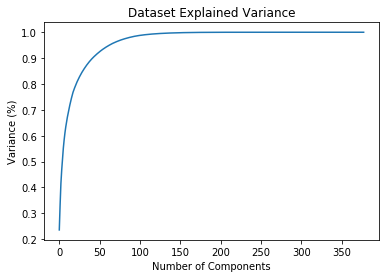

In [33]:

data4=data3.copy()
pca = PCA().fit(data4)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()


Since I don't know that much about the dataset and the background, I want to be conservative about the # of variables I kept after PCA. (I chose 6) Although it probably only can explain less than 50% variance, it will still be a good detector.

In [34]:
#T avoid the overfitting and the lack of information, we’ll not use 100% of our variance,I chose to keep 25 dimensions.It makes sense I think, because it denotes all components, and we want only the principal ones.
pca=PCA(n_components=6,copy=False)#pca
data4=pca.fit_transform(data4)

3.4 Zscale

In [35]:
data5=pd.DataFrame(preprocessing.scale(data4))

In [36]:
data6=data5.copy()

In [37]:
data6.head()

,0,1,2,3,4,5
0,0.075721,-0.447174,-0.387791,1.555332,-0.630471,-1.464604
1,-0.152395,0.171476,-0.008330,1.667329,-0.628915,-1.263260
2,0.102546,-0.062011,-0.704474,1.827938,-0.290216,-0.566668
3,0.331110,-1.355811,-0.184775,0.731921,0.625114,2.658777
4,0.186673,-1.361668,0.015788,1.382423,0.228699,1.253488


3.5 The First Score Computation

In [38]:
for i in data5.columns:
    data5[i] = data5[i].apply(lambda x: x**2)
data5['score1']  = data5.sum(axis = 1)
data5['score1'] = data5['score1'].apply(lambda x: x**0.5)

In [39]:
data5['score1'].max()

10.626783491827922

3.6 Autoencoder Score
* The architecture of the autoencoder: 6 nodes, 3 nodes and 6 nodes.

In [40]:
#autoencoder score part
import pickle
from scipy import stats
import tensorflow as tf
# from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [41]:
## autoencoder model  --- takes time to run
components_train = data6.values

input_dim = data6.shape[1]
encoding_dim =6



input_layer = Input(shape=(input_dim, ))
#encoder = Dense(encoding_dim, activation="elu", 
#               activity_regularizer=regularizers.l1(10e-5))(input_layer)    # for classification variables

encoder = Dense(int(encoding_dim / 2), activation="relu")(input_layer)
decoder = Dense(int(encoding_dim / 2), activation='elu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)


nb_epoch = 10
batch_size = 1024
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(components_train, components_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                   # validation_data=(X_test, X_test),
                    verbose=1,
                   callbacks=[checkpointer, tensorboard]
                    ).history

Epoch 1/10
447/447 [==============================] - 0s 380us/step - loss: 1.0282 - acc: 0.2416
Epoch 2/10
447/447 [==============================] - 0s 9us/step - loss: 1.0261 - acc: 0.2662
Epoch 3/10
447/447 [==============================] - 0s 11us/step - loss: 1.0240 - acc: 0.2662
Epoch 4/10
447/447 [==============================] - 0s 4us/step - loss: 1.0219 - acc: 0.2662
Epoch 5/10
447/447 [==============================] - 0s 7us/step - loss: 1.0199 - acc: 0.2662
Epoch 6/10
447/447 [==============================] - 0s 9us/step - loss: 1.0179 - acc: 0.2685
Epoch 7/10
447/447 [==============================] - 0s 11us/step - loss: 1.0160 - acc: 0.2707
Epoch 8/10
447/447 [==============================] - 0s 11us/step - loss: 1.0140 - acc: 0.2707
Epoch 9/10
447/447 [==============================] - 0s 4us/step - loss: 1.0121 - acc: 0.2774
Epoch 10/10
447/447 [==============================] - 0s 4us/step - loss: 1.0103 - acc: 0.2819


C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


In [42]:
components_train

array([[ 0.07572108, -0.44717433, -0.38779095,  1.55533163, -0.63047125,
        -1.46460376],
       [-0.15239509,  0.17147644, -0.00833043,  1.66732928, -0.62891476,
        -1.26326016],
       [ 0.10254588, -0.06201102, -0.70447423,  1.8279382 , -0.29021611,
        -0.56666759],
       ...,
       [ 0.00504333, -0.69726582, -0.6141716 , -0.05318351, -0.13850103,
         0.02790803],
       [ 0.00429152, -0.68293688,  0.14282056,  0.89595328,  0.0242497 ,
         0.12523867],
       [ 0.0037521 , -0.45441789,  0.00964075, -0.54108751,  0.47102596,
        -0.55175948]])

In [43]:
names=[]
for i in range(6):
    names.append('x'+str(i))

In [44]:
data6.head()

,0,1,2,3,4,5
0,0.075721,-0.447174,-0.387791,1.555332,-0.630471,-1.464604
1,-0.152395,0.171476,-0.008330,1.667329,-0.628915,-1.263260
2,0.102546,-0.062011,-0.704474,1.827938,-0.290216,-0.566668
3,0.331110,-1.355811,-0.184775,0.731921,0.625114,2.658777
4,0.186673,-1.361668,0.015788,1.382423,0.228699,1.253488


In [45]:
predictions = autoencoder.predict(components_train)
predictions = pd.DataFrame.from_records(predictions, columns = names )
data6.columns=names
for i in names:
    predictions[''.join([i, '_', "diff"])] = abs(data6.loc[:,i] - predictions.loc[:,i])

In [46]:
predictions['autoencodererr_score'] =  predictions.apply(lambda x:x*x).apply(sum, axis =1)**0.5

In [47]:
processed_df = pd.DataFrame()
processed_df[['autoencodererr_score']] = predictions[['autoencodererr_score']]
processed_df['score1'] = data5[['score1']]

In [48]:
data5.head()

,0,1,2,3,4,5,score1
0,0.005734,0.199965,0.150382,2.419056,0.397494,2.145064,2.306013
1,0.023224,0.029404,0.000069,2.779987,0.395534,1.595826,2.196371
2,0.010516,0.003845,0.496284,3.341358,0.084225,0.321112,2.063332
3,0.109634,1.838224,0.034142,0.535708,0.390768,7.069093,3.158729
4,0.034847,1.854139,0.000249,1.911094,0.052303,1.571233,2.328919


In [49]:
processed_df['flight']=flight_lst
processed_df.set_index(["flight"], inplace=True)

In [50]:
processed_df.head()

,autoencodererr_score,score1
flight,,
16951,2.386602,2.306013
16952,2.329266,2.196371
16954,2.106791,2.063332
16955,3.160271,3.158729
16957,2.326876,2.328919


3.7 Obtain the rank based on the autoencoder score and combine two ranks to get the final score

In [51]:
processed_df['rankorder']= processed_df['score1'].rank(method='first', ascending = True)
processed_df = processed_df.sort_values(by = 'score1', ascending = False)
auto = processed_df[['autoencodererr_score']]
del processed_df['autoencodererr_score']
auto['rankorders']= auto['autoencodererr_score'].rank(method='first', ascending = True)
auto = auto.sort_values(by = 'autoencodererr_score', ascending = False)
auto = auto.merge(processed_df, left_index=True, right_index=True)
auto['final'] = auto.apply(lambda x: (x['rankorder'] + x['rankorders'])/2, axis = 1)
auto = auto.sort_values(by = 'final', ascending=False)

* Now, the auto dataframe is the final output for anomaly detection, which ranks the extent of anomaly(final) in a descending order. The higher the records rank, the more possible thay are outliers. I will just truncate the first 6 to take a look.

In [52]:
auto[:6]

,autoencodererr_score,rankorders,score1,rankorder,final
flight,,,,,
17136,10.435665,447.0,10.583369,446.0,446.5
17437,10.128508,446.0,10.626783,447.0,446.5
17438,10.046853,445.0,10.481993,445.0,445.0
17439,9.968261,444.0,10.469834,444.0,444.0
16987,7.029152,443.0,7.029594,442.0,442.5
17030,7.028833,442.0,7.327591,443.0,442.5


Let's zoom in to see the performance for every flight, taking flight 17437 and 17136 as example.

In [53]:
zscore=pd.DataFrame(data3,columns=col_lst)
zscore['flight']=flight_lst
zscore.set_index(["flight"], inplace=True)

In [54]:
f_17437=zscore[zscore.index==17437].transpose()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


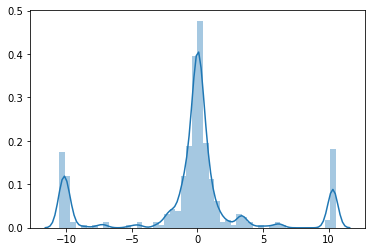

In [55]:
# The distribution the Zscore before PCA
sns.distplot(list(f_17437.values))

In [56]:
pd.options.display.max_columns = None
f_17437[(f_17437[17437]>10.5)|(f_17437[17437]<-10.5)]

flight,17437
o2_1,-10.524086
o2_2,-10.524078
o2_3,-10.524086
o2_4,-10.524082
o2_5,-10.525019
v0_6,10.521713
o2_6,-10.546775
v0_7,10.544525
o2_7,-10.507853
p0_8,10.500775


Therefore, The following elements are strongly deviated from the general trend. 
* The Euler (Tait-Bryan) yaw of the zip for the first 7 seconds starting from time-counting(-5s), that is during the 2nd second after launch.
* The velocity of the zip in the north direction at the sixth and seventh second starting from time-counting(-5s),  
* The position of the zip relative to a fixed reference point in the north direction at the 8th second starting from time-counting(-5s).

This flight is probably one of the few flights whose flying directions are on the opposite side.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


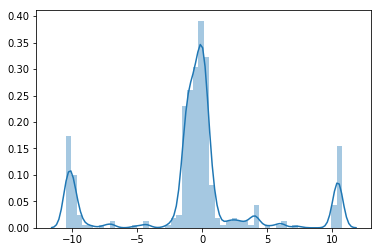

In [57]:
#17136
f_17136=zscore[zscore.index==17136].transpose()
sns.distplot(list(f_17136.values))

In [60]:
pd.options.display.max_columns = None
f_17136[(f_17136[17136]>10.5)|(f_17136[17136]<-10.5)]

flight,17136
o2_1,-10.523867
o2_2,-10.523877
o2_3,-10.523874
o2_4,-10.523876
o2_5,-10.523353
o2_6,-10.511750
v0_7,10.541509
p0_8,10.533946
p0_9,10.525310
v0_18,10.535177


Therefore, The following elements are strongly deviated from the general trend. 
* The Euler (Tait-Bryan) yaw of the zip for the first 6 seconds starting from the time-counting(-5s).
* The velocity of the zip in the north direction between the 18th and 21st second starting from time-counting(-5s),  
* The position of the zip relative to a fixed reference point in the north direction at the 8th,21st and 9th second starting from time-counting(-5s).

This flight is also probably one of the few flights whose flying directions are the opposite side compared with the other majority.
* If the differnt launching orientation is decided by orders and we consider them as normal, we can just filter out these flights,like 17437 and 17136, whose variables with the highest zscores are orientations, and then analyze other records.

4.1 Weather Seasonality 

I plotted the variation of all five environmental variables and set the xticks to per day.Also, if we want to take one more step, we can plot all periods on top of each other, calculate average shape factor, but only look for a statistically meaningful shape factor by comparing stdev of periods to max deviation in shape factor .

In [61]:
import datetime
from datetime import timedelta
summary=pd.read_csv('summary_data.csv')
summary['launch_timestamp']=pd.to_datetime(summary['launch_timestamp'])

C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname CAT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


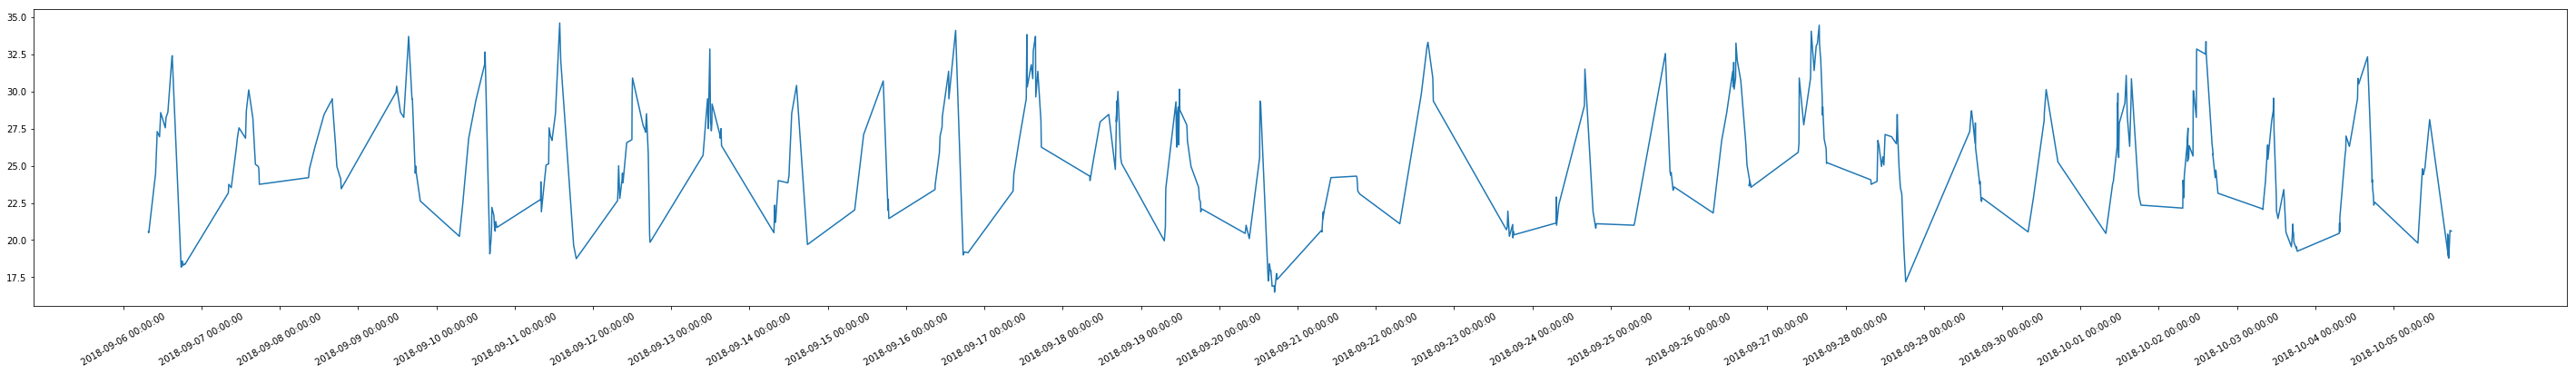

In [62]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import numpy as np
%matplotlib inline
x=summary['launch_timestamp']
y=summary['air_temperature']
tick_spacing =20
fig, ax = plt.subplots(1,1,figsize=(50,6))
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.plot(x,y)
plt.xticks(pd.date_range('2018-09-06','2018-10-05'),rotation=30)
plt.show()

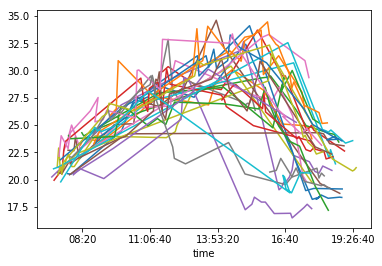

In [124]:
#plot everyday air temperature on top of each other to see the seasonality
summary['date']=summary['launch_timestamp'].dt.day
summary['datetime'] =summary['day']=summary['launch_timestamp'].dt.time
summary['day']=summary['launch_timestamp'].dt.date
dates=summary['day'].unique()
for i in dates:
    plt.plot(summary[summary['day']==i]['datetime'],summary[summary['day']==i]['air_temperature'])


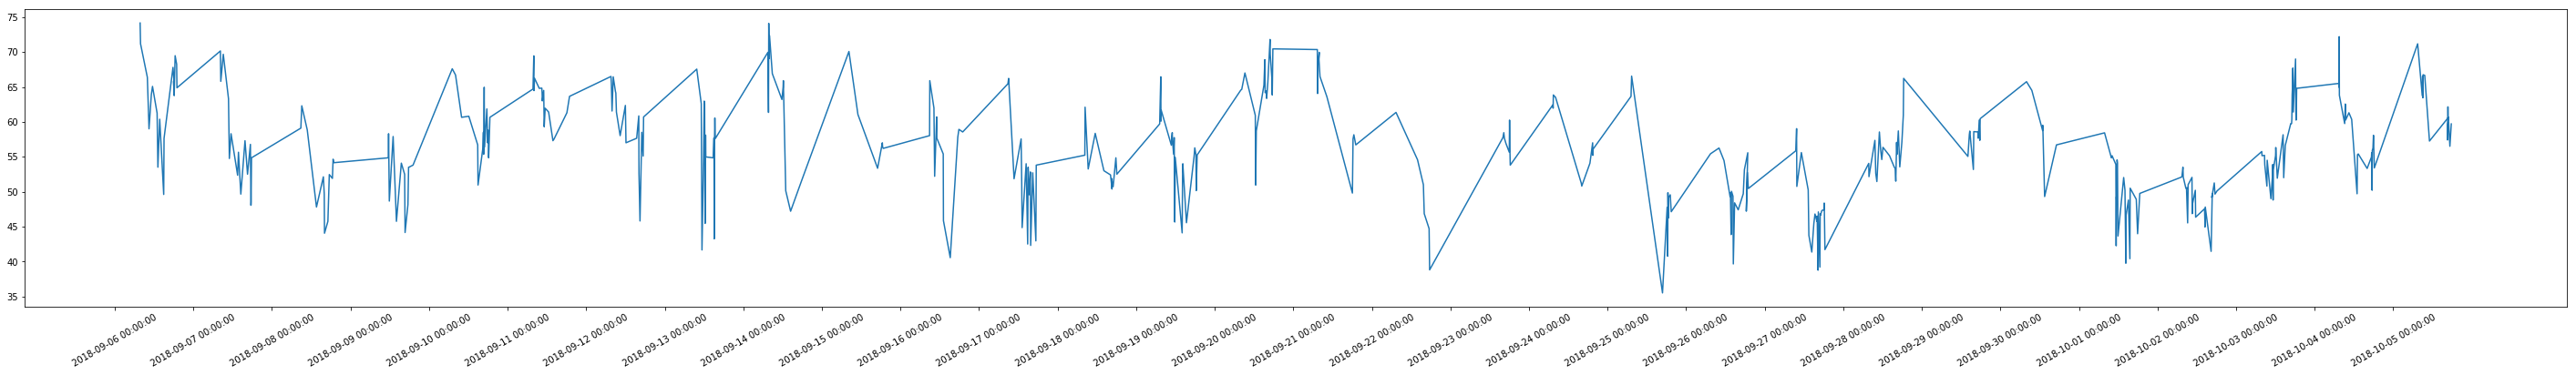

In [63]:
x=summary['launch_timestamp']
y=summary['rel_humidity']
tick_spacing =20
fig, ax = plt.subplots(1,1,figsize=(50,6))
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.plot(x,y)
plt.xticks(pd.date_range('2018-09-06','2018-10-05'),rotation=30)
plt.show()

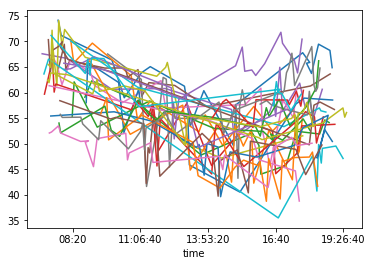

In [125]:
#plot everyday humidity on top of each other to see the seasonality
for i in dates:
    plt.plot(summary[summary['day']==i]['datetime'],summary[summary['day']==i]['rel_humidity'])

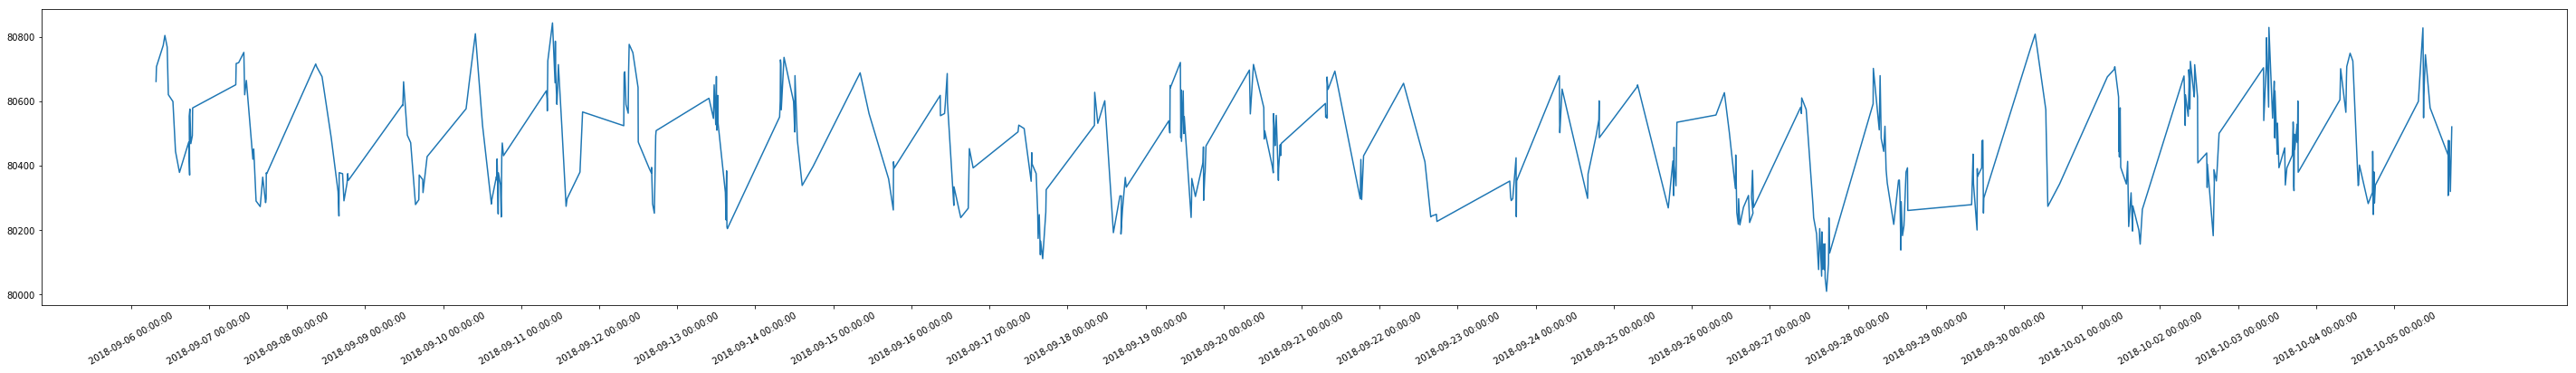

In [64]:
x=summary['launch_timestamp']
y=summary['static_pressure']
tick_spacing =20
fig, ax = plt.subplots(1,1,figsize=(50,6))
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.plot(x,y)
plt.xticks(pd.date_range('2018-09-06','2018-10-05'),rotation=30)
plt.show()

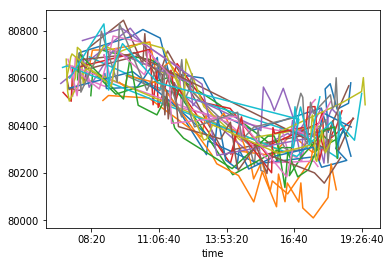

In [126]:
#plot everyday static pressure on top of each other to see the seasonality
for i in dates:
    plt.plot(summary[summary['day']==i]['datetime'],summary[summary['day']==i]['static_pressure'])

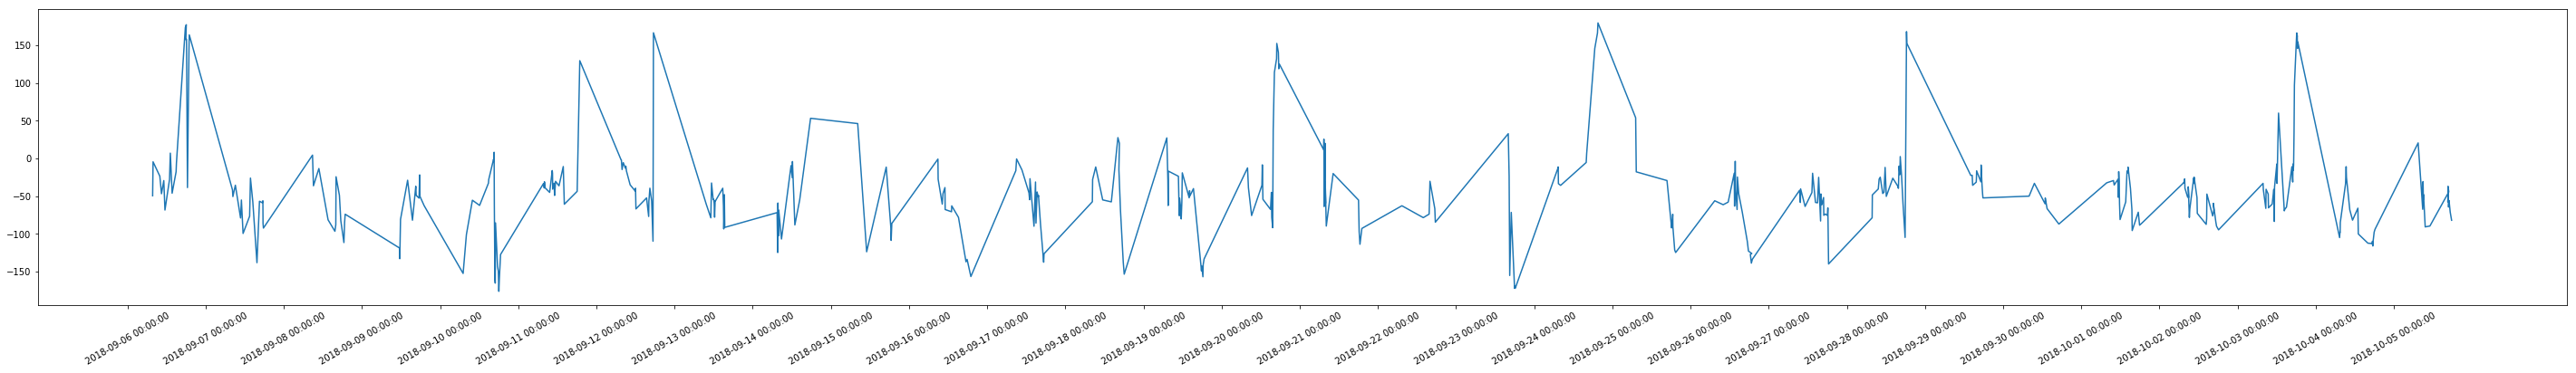

In [65]:
x=summary['launch_timestamp']
y=summary['wind_direction']
tick_spacing =20
fig, ax = plt.subplots(1,1,figsize=(50,6))
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.plot(x,y)
plt.xticks(pd.date_range('2018-09-06','2018-10-05'),rotation=30)
plt.show()

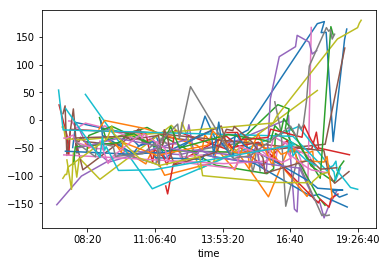

In [127]:
#plot everyday wind direction on top of each other to see the seasonality
for i in dates:
    plt.plot(summary[summary['day']==i]['datetime'],summary[summary['day']==i]['wind_direction'])

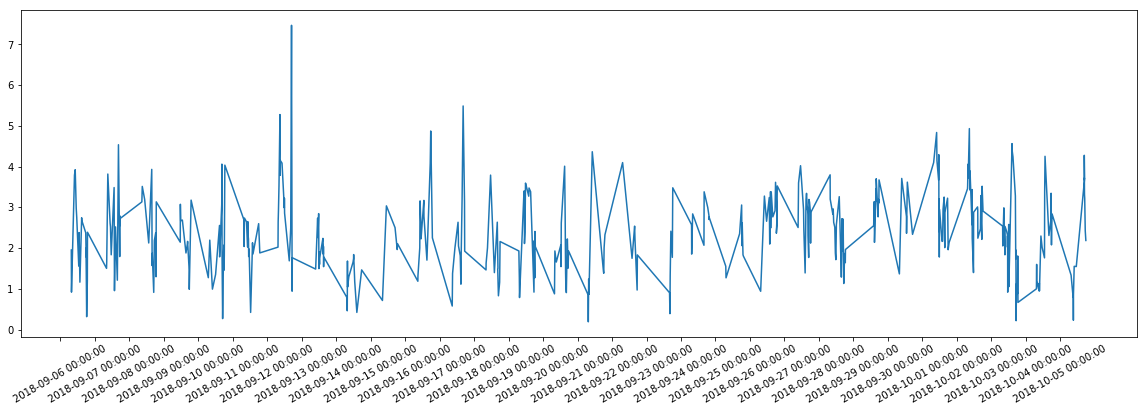

In [66]:
x=summary['launch_timestamp']
y=summary['wind_magnitude']
tick_spacing =20
fig, ax = plt.subplots(1,1,figsize=(20,6))
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.plot(x,y)
plt.xticks(pd.date_range('2018-09-06','2018-10-05'),rotation=30)
plt.show()

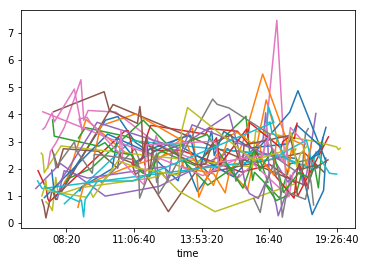

In [128]:
#plot everyday wind_magnitude on top of each other to see the seasonality
for i in dates:
    plt.plot(summary[summary['day']==i]['datetime'],summary[summary['day']==i]['wind_magnitude'])

Obviously, air_temperature, rel_humidity, and static_pressure have seasonality on day scale and static pressure has the most clear pattern.

They generally arrive the highest value during the middle of the day, although the peak hours are different. However, the wind_direction and wind_magnitude still need more validations to test the seasonality.

For testing, we can smooth, standardize, and normalization the time series data, and finally calcualte the DTW(Warp-Path-Distance) to measure the similarity of data between different time intervals. 

4.2 poorly performing parts

In [90]:
#filter the first 50 flights that have the highest anomaly score.
df_50=auto[:50]
performance=df_50.merge(summary[['flight_id','battery_serial_number','body_serial_number','wing_serial_number']],left_on=df_50.index,right_on='flight_id')

In [91]:
performance.head()

,autoencodererr_score,rankorders,score1,rankorder,final,flight_id,battery_serial_number,body_serial_number,wing_serial_number
0,10.435665,447.0,10.583369,446.0,446.5,17136,15SPJJJ10027028,577350132840894487,15SPJJJ09043062
1,10.128508,446.0,10.626783,447.0,446.5,17437,15SPJJJ10048030,577350132840857611,15SPJJJ09024061
2,10.046853,445.0,10.481993,445.0,445.0,17438,15SPJJJ10022048,577350132807348254,15SPJJJ09040032
3,9.968261,444.0,10.469834,444.0,444.0,17439,15SPJJJ10023027,577348835962105883,15SPJJJ09019061
4,7.029152,443.0,7.029594,442.0,442.5,16987,15SPJJJ10052026,577350132807348254,15SPJJJ09011032


In [98]:
performance['battery_serial_number'].value_counts().head()

15SPJJJ10056048    4
15SPJJJ10040016    4
15SPJJJ09036021    4
15SPJJJ10018016    3
15SPJJJ10052026    3
Name: battery_serial_number, dtype: int64

Therefore, the battery numbers above are the top 5 batteries that appears the most frequent amongst the outliers.

In [99]:
performance['body_serial_number'].value_counts().head()

577209618523082792    9
577350132840857611    7
577350132807348254    6
577348835962155029    5
577350132790558758    4
Name: body_serial_number, dtype: int64

Body numbers above are the top 5 bodies that appears the most frequent amongst the outliers.

In [100]:
performance['wing_serial_number'].value_counts().head()

15SPJJJ09040032    8
15SPJJJ11049056    6
15SPJJJ09008034    6
15SPJJJ09019061    6
15SPJJJ09025064    5
Name: wing_serial_number, dtype: int64

Wing numbers above are the top 5 wings that appears the most frequent amongst the outliers.

Thanks for the reading. Finally,that's the end.